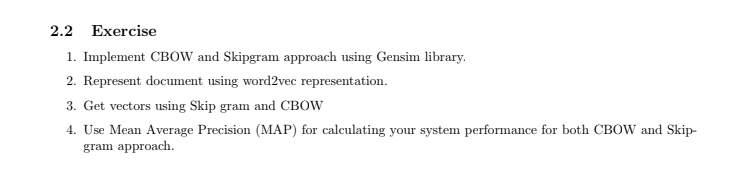

In [ ]:
import glob

downloading and unzipping data

In [ ]:
%%capture
!gdown https://drive.google.com/uc?id=1JuawXQmYVkjpfL3H0blqjDrqw8V1lHrC
!unrar e /content/FIRE_Dataset_EN_2010.rar
!gunzip /content/en.qrels.76-125.2010.txt.gz
!tar -xzvf English-Data.tgz

In [ ]:
pip install --upgrade gensim

     |████████████████████████████████| 24.2MB 156kB/s 
  Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


Importing documents, Queries 

In [ ]:
files = {}
for file in glob.iglob("TELEGRAPH_UTF8/**/*.utf8", recursive=True):
  files[file.split('/')[-1]] = open(file)

In [ ]:
e = open("/content/en.qrels.76-125.2010.txt")
q = open("/content/en.topics.76-125.2010.txt")

In [ ]:
estr = e.read()
qstr = q.read()

In [ ]:
import numpy as np
import pandas as pd
import os
from bs4 import BeautifulSoup
import nltk

In [ ]:

es = estr.split("\n")
elist = [est for est in es if est.endswith('1')]

edir = {}
for e in elist:
  a, b, c, d = e.split()
  if a not in edir:
    edir[a] = [c]
  else:
    edir[a].append(c)


I'll  be using title and desc texts for retrieval

In [ ]:
import re
ls = qstr.split('</top>')[:-1]
Queries={}
for query in ls:
  soup = BeautifulSoup(query, 'lxml')
  n = soup.find('num').text
  s = soup.find('desc').text
  s += soup.find('title').text
  # s = soup.find('narr').text
  
  Queries[n] = s
Queries

{'100': '\nMonica Bedi charged with obtaining forged passports at\nHyderabad.\nMonica Bedi and the passport forgery case',
 '101': "\nDetails of the drink-and-drugs party at the late Pramod\nMahajan's official bungalow in which Rahul (his son), Bibek\nMoitra, and possibly others were involved.\nDrug party at Pramod Mahajan's bungalow",
 '102': '\nCharges of doping against Shoaib Akhtar and Mohammad Asif.\nPakistani cricketers involved in a doping scandal',
 '103': "\nWhat is India's position on the Indo-Pak conflict over the\nBaglihar hydro-electric power project?\nBilateral problems surrounding the Baglihar hydro-electric\npower project",
 '104': '\nWhat legal steps has Jaya Bachchan taken on being\ndisqualified from Rajya Sabha membership for holding an\noffice of profit?\nJaya Bachchan sacked from Rajya Sabha membership',
 '105': '\nCBI investigations into the alleged involvement of the Chief\nMinister and highly placed bureaucrats of Uttar Pradesh in\nthe multi-crore Taj heritage c

Let's first create word vectors

In [ ]:
from gensim.test.utils import datapath
from gensim import utils

class MyCorpus:
  """An iterator that yields sentences (lists of str)."""

  def __iter__(self):
    for file in files:
      yield utils.simple_preprocess(files[file].read())


In [ ]:
sentences = MyCorpus()

let's train both the models cobow and skip gram

In [ ]:
import gensim.models

skipmodel = gensim.models.Word2Vec(sentences=sentences, sg=1, size=300, window=5, workers=2)



Preprocessing stuffs

In [ ]:

def tokenize_words(text):
  """
  The function tokenizes the words removes special characters, numbers and returns list of lowercase tokens
  """
  text = text.lower()
  tokens = nltk.regexp_tokenize(text, '[a-zA-Z]+', gaps=False)
  
  return tokens

nltk.download('stopwords')
from nltk.corpus import stopwords
# from nltk.stem import 	WordNetLemmatizer
# wnl = WordNetLemmatizer()
nltk.download('wordnet')

def remove_stopwords(words):
  """
  Removes the stop words from a list of words
  """
  engstopwords = stopwords.words('english')
  nostopwords = filter(lambda x: x not in engstopwords and len(x) != 1, words)
  return list(nostopwords)



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
def lemmatize(words):
  """
  prints the word and lemmatized word and also returns the list of lemmatized words
  """
  lemmatizedwords = [wnl.lemmatize(word) for word in words]
  return lemmatizedwords

In [ ]:
def preprocess(text):
  return remove_stopwords(utils.simple_preprocess(text))

In [ ]:
files = {}
for file in glob.iglob("TELEGRAPH_UTF8/**/*.utf8", recursive=True):
  files[file.split('/')[-1]] = open(file)

In [ ]:
processDocs = lambda x: {doc:preprocess(x[doc].read()) for doc in x}

In [ ]:
docs = processDocs(files)

In [ ]:
words=[]
for wrds in docs.values():
      words.extend(wrds)
wordSet = set(words)

In [ ]:
model = skipmodel

# skip gram

In [ ]:
docV = {}
for doc in docs:
  docV[doc] = sum([model.wv[word] for word in docs[doc] if word in wordSet and word in model.wv])


In [ ]:
QueriesP = {}
for id in Queries:
  QueriesP[id] = preprocess(Queries[id])


Let's create vectors using skip gram

In [ ]:
QueriesV = {}
for id in QueriesP:
  QueriesV[id] = sum([model.wv[word] for word in QueriesP[id] if word in wordSet and word in model.wv])

In [ ]:
def cosineSim(a, b):
  an = np.linalg.norm(a)
  bn = np.linalg.norm(b)
  if an == 0 or bn == 0:
    return 0

  return np.dot(a, b)/(an*bn)
docmeas = {}
for query in QueriesV:
  ls = []
  for doc in docV:
      ls.append((query, doc, cosineSim(docV[doc], QueriesV[query])))
  docmeas[query] = ls


In [ ]:
for query in docmeas:
  docmeas[query].sort(key=lambda x: x[2], reverse=True)

In [ ]:
for query in Queries:
  docmeas[query] = docmeas[query][:len(edir[query])]

docmeas

{'100': [('100', '1051115_nation_story_5478696.utf8', 0.47377715),
  ('100', '1051125_nation_story_5520551.utf8', 0.4380817),
  ('100', '1051112_frontpage_story_5468137.utf8', 0.43219927),
  ('100', '1041110_nation_story_3987208.utf8', 0.375738),
  ('100', '1050810_nation_story_5095926.utf8', 0.37488183),
  ('100', '1051206_nation_story_5564372.utf8', 0.37289795),
  ('100', '1051213_nation_story_5593623.utf8', 0.3639774),
  ('100', '1070720_nation_story_8082600.utf8', 0.36027274),
  ('100', '1051120_nation_story_5499251.utf8', 0.35750636),
  ('100', '1070331_nation_story_7589508.utf8', 0.35715598),
  ('100', '1070726_nation_story_8107361.utf8', 0.35605833),
  ('100', '1060405_nation_story_6059195.utf8', 0.3438342),
  ('100', '1041004_nation_story_3838101.utf8', 0.34360552),
  ('100', '1070518_nation_story_7794373.utf8', 0.3396618),
  ('100', '1051112_nation_story_5468011.utf8', 0.33898282),
  ('100', '1070724_nation_story_8096554.utf8', 0.3347976),
  ('100', '1051208_nation_story_55728

In [ ]:
docmeas1 = {}
for query in QueriesP:
  docmeas1[query] = [(c[1], 1 if c[1] in edir[query] else 0) for c in docmeas[query]]
docmeas1

{'100': [('1051115_nation_story_5478696.utf8', 1),
  ('1051125_nation_story_5520551.utf8', 0),
  ('1051112_frontpage_story_5468137.utf8', 1),
  ('1041110_nation_story_3987208.utf8', 1),
  ('1050810_nation_story_5095926.utf8', 1),
  ('1051206_nation_story_5564372.utf8', 1),
  ('1051213_nation_story_5593623.utf8', 1),
  ('1070720_nation_story_8082600.utf8', 0),
  ('1051120_nation_story_5499251.utf8', 0),
  ('1070331_nation_story_7589508.utf8', 0),
  ('1070726_nation_story_8107361.utf8', 1),
  ('1060405_nation_story_6059195.utf8', 0),
  ('1041004_nation_story_3838101.utf8', 0),
  ('1070518_nation_story_7794373.utf8', 1),
  ('1051112_nation_story_5468011.utf8', 1),
  ('1070724_nation_story_8096554.utf8', 0),
  ('1051208_nation_story_5572807.utf8', 0),
  ('1050227_nation_story_4430335.utf8', 1),
  ('1070718_nation_story_8073172.utf8', 0),
  ('1060930_nation_story_6812663.utf8', 0),
  ('1051123_frontpage_story_5511154.utf8', 1)],
 '101': [('1060423_nation_story_6134147.utf8', 0),
  ('1061125

In [ ]:
queryap = {}
for query in QueriesV:
  gtp = len(edir[query])
  p = 0
  i = 0
  for j in range(len(docmeas1[query])):
    if docmeas1[query][j][1] == 1:
      i += 1
      p += i/(j+1)
  queryap[query] = 1/gtp * p

In [ ]:

MAP = sum(queryap.values())/ len(queryap)

In [ ]:
MAP

0.33584130757254427

# change

In [ ]:
files = {}
for file in glob.iglob("TELEGRAPH_UTF8/**/*.utf8", recursive=True):
  files[file.split('/')[-1]] = open(file)
sen = MyCorpus()
cobowmodel = gensim.models.Word2Vec(sentences=sen, sg=0, size=300, window=5, workers=2)

In [ ]:
model = cobowmodel

# Cobow

In [ ]:
docV = {}
for doc in docs:
  docV[doc] = sum([model.wv[word] for word in docs[doc] if word in wordSet and word in model.wv])


In [ ]:
QueriesP = {}
for id in Queries:
  QueriesP[id] = preprocess(Queries[id])


Let's create vectors using cobow

In [ ]:
QueriesV = {}
for id in QueriesP:
  QueriesV[id] = sum([model.wv[word] for word in QueriesP[id] if word in wordSet and word in model.wv])

In [ ]:
def cosineSim(a, b):
  an = np.linalg.norm(a)
  bn = np.linalg.norm(b)
  if an == 0 or bn == 0:
    return 0

  return np.dot(a, b)/(an*bn)
docmeas = {}
for query in QueriesV:
  ls = []
  for doc in docV:
      ls.append((query, doc, cosineSim(docV[doc], QueriesV[query])))
  docmeas[query] = ls


In [ ]:
for query in docmeas:
  docmeas[query].sort(key=lambda x: x[2], reverse=True)

In [ ]:
for query in Queries:
  docmeas[query] = docmeas[query][:len(edir[query])]

docmeas

{'100': [('100', '1051115_nation_story_5478696.utf8', 0.47377715),
  ('100', '1051125_nation_story_5520551.utf8', 0.4380817),
  ('100', '1051112_frontpage_story_5468137.utf8', 0.43219927),
  ('100', '1041110_nation_story_3987208.utf8', 0.375738),
  ('100', '1050810_nation_story_5095926.utf8', 0.37488183),
  ('100', '1051206_nation_story_5564372.utf8', 0.37289795),
  ('100', '1051213_nation_story_5593623.utf8', 0.3639774),
  ('100', '1070720_nation_story_8082600.utf8', 0.36027274),
  ('100', '1051120_nation_story_5499251.utf8', 0.35750636),
  ('100', '1070331_nation_story_7589508.utf8', 0.35715598),
  ('100', '1070726_nation_story_8107361.utf8', 0.35605833),
  ('100', '1060405_nation_story_6059195.utf8', 0.3438342),
  ('100', '1041004_nation_story_3838101.utf8', 0.34360552),
  ('100', '1070518_nation_story_7794373.utf8', 0.3396618),
  ('100', '1051112_nation_story_5468011.utf8', 0.33898282),
  ('100', '1070724_nation_story_8096554.utf8', 0.3347976),
  ('100', '1051208_nation_story_55728

In [ ]:
docmeas1 = {}
for query in QueriesP:
  docmeas1[query] = [(c[1], 1 if c[1] in edir[query] else 0) for c in docmeas[query]]
docmeas1

{'100': [('1051115_nation_story_5478696.utf8', 1),
  ('1051125_nation_story_5520551.utf8', 0),
  ('1051112_frontpage_story_5468137.utf8', 1),
  ('1041110_nation_story_3987208.utf8', 1),
  ('1050810_nation_story_5095926.utf8', 1),
  ('1051206_nation_story_5564372.utf8', 1),
  ('1051213_nation_story_5593623.utf8', 1),
  ('1070720_nation_story_8082600.utf8', 0),
  ('1051120_nation_story_5499251.utf8', 0),
  ('1070331_nation_story_7589508.utf8', 0),
  ('1070726_nation_story_8107361.utf8', 1),
  ('1060405_nation_story_6059195.utf8', 0),
  ('1041004_nation_story_3838101.utf8', 0),
  ('1070518_nation_story_7794373.utf8', 1),
  ('1051112_nation_story_5468011.utf8', 1),
  ('1070724_nation_story_8096554.utf8', 0),
  ('1051208_nation_story_5572807.utf8', 0),
  ('1050227_nation_story_4430335.utf8', 1),
  ('1070718_nation_story_8073172.utf8', 0),
  ('1060930_nation_story_6812663.utf8', 0),
  ('1051123_frontpage_story_5511154.utf8', 1)],
 '101': [('1060423_nation_story_6134147.utf8', 0),
  ('1061125

In [ ]:
QueriesP['94']

['investigations',
 'accusations',
 'classified',
 'information',
 'leaked',
 'indian',
 'navy',
 'indian',
 'navy',
 'accused',
 'leaking',
 'classified',
 'information']

In [ ]:
queryap = {}
for query in QueriesV:
  gtp = len(edir[query])
  p = 0
  i = 0
  for j in range(len(docmeas1[query])):
    if docmeas1[query][j][1] == 1:
      i += 1
      p += i/(j+1)
  queryap[query] = 1/gtp * p

In [ ]:

MAP = sum(queryap.values())/ len(queryap)

In [ ]:
MAP

0.32362889638808817